Importing Modules

In [11]:
import pandas as pd
import numpy as np
import nltk
import re
import contractions
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
import pyLDAvis

Download required data for NLTK

In [3]:
    
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/hamza-
[nltk_data]     mahmood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Clustering algorithm 

In [20]:
class ReviewClustering:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def preprocess_text(self, text):
        """Implements all preprocessing steps."""
        # Handle NaN values
        if pd.isna(text):
            return []
            
        # Convert to string if not already
        text = str(text)
        
        # Expand contractions
        text = contractions.fix(text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        
        # Tokenization
        tokens = text.split()
        
        # Filter tokens to keep only alphabetic words
        tokens = [token for token in tokens if token.isalpha()]
        
        # Get POS tags and keep only nouns and adjectives
        if tokens:
            try:
                pos_tags = pos_tag(tokens)
                tokens = [word for word, pos in pos_tags 
                        if pos.startswith('NN') or pos.startswith('JJ')]
            except Exception as e:
                print(f"POS tagging failed for tokens: {tokens}")
                print(f"Error: {e}")
                tokens = []  # Return an empty list on failure
        else:
            tokens = []  # Handle case where tokens are empty
        
        # Lemmatization
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        
        return tokens


    def create_bigrams(self, texts):
        """Create bigrams from preprocessed texts"""
        # Filter out empty lists
        texts = [text for text in texts if text]
        if not texts:
            raise ValueError("No valid texts after preprocessing")
            
        phrases = Phrases(texts, min_count=5, threshold=100)
        bigram = Phraser(phrases)
        return [bigram[doc] for doc in texts]

    def train_lda_model(self, texts, num_topics=6):
        """Train LDA model and compute coherence score"""
        # Create dictionary
        dictionary = Dictionary(texts)
        dictionary.filter_extremes(no_below=5, no_above=0.5)
        
        # Create corpus
        corpus = [dictionary.doc2bow(text) for text in texts]
        
        # Check if corpus is empty
        if not corpus:
            raise ValueError("Empty corpus - no valid documents for training")
        
        # Train LDA model
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        
        # Compute coherence score
        coherence_model = CoherenceModel(
            model=lda_model, 
            texts=texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        
        return lda_model, dictionary, corpus, coherence_score

    def get_dominant_topic(self, lda_model, corpus):
        """Get dominant topic for each document"""
        dominant_topics = []
        for doc in corpus:
            topic_probs = lda_model.get_document_topics(doc)
            if topic_probs:  # Check if there are any topics
                dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
            else:
                dominant_topic = -1  # Assign -1 for documents without clear topic
            dominant_topics.append(dominant_topic)
        return dominant_topics

    def cluster_reviews(self, reviews_df, asin):
    # Filter reviews for the specified ASIN
        product_reviews = reviews_df[reviews_df["asin"] == asin].copy()
        if product_reviews.empty:
            raise ValueError(f"No reviews found for ASIN: {asin}")
        
        print(f"Number of reviews found for ASIN {asin}: {len(product_reviews)}")

        # Preprocess reviews
        processed_reviews = [
            self.preprocess_text(review)
            for review in product_reviews["reviewText"]
        ]
        
        # Drop reviews that resulted in empty tokens
        product_reviews = product_reviews.iloc[:len(processed_reviews)]
        processed_reviews = [tokens for tokens in processed_reviews if tokens]

        # Create bigrams
        reviews_with_bigrams = self.create_bigrams(processed_reviews)

        # Create dictionary and corpus
        dictionary = Dictionary(reviews_with_bigrams)
        corpus = [dictionary.doc2bow(tokens) for tokens in reviews_with_bigrams]

        # Train LDA model and calculate coherence score
        best_model = None
        best_coherence = -1
        coherence_score_list = []
        for num_topics in range(2, 21):  # Test 2 to 5 topics
            model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=50)
            coherence_model = CoherenceModel(model=model, texts=reviews_with_bigrams, dictionary=dictionary, coherence="c_v")
            coherence_score = coherence_model.get_coherence()
            coherence_score_list.append(coherence_score)
            if coherence_score > best_coherence:
                best_model = model
                best_coherence = coherence_score
        plt.figure(figsize=(10, 5))
        plt.plot(range(2, 21), coherence_score_list, marker='o')
        plt.title('Coherence Score vs. Number of Topics')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score')
        plt.show()
        

        # Get dominant topics
        dominant_topics = self.get_dominant_topic(best_model, corpus)

        # Add cluster labels to the DataFrame
        product_reviews = product_reviews.iloc[:len(dominant_topics)].copy()
        product_reviews["cluster"] = dominant_topics

        # Get top words for each topic
        topics_words = {}
        for topic_id in range(best_model.num_topics):
            words = best_model.show_topic(topic_id, topn=5)
            topics_words[topic_id] = [word for word, _ in words]

            
        # Visualize topics with pyLDAvis
        vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
        pyLDAvis.save_html(vis, 'clustering_insights.html')

        return product_reviews, topics_words, best_coherence

Reading dataset

In [4]:
reviews_df = pd.read_json("Electronics_5.json", lines = True)

Creating LDA model


Number of reviews found for ASIN B0019EHU8G: 3435


/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarnin

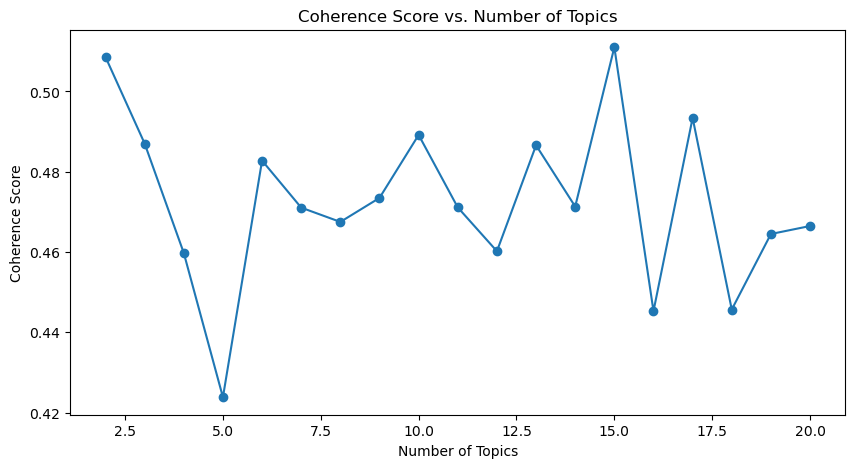

/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/hamza-mahmood/anaconda3/envs/ML/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=31049) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/hamza-mahm

Coherence score: 0.5110105991918151

Top words for each topic:
Topic 0: ok, noise, worst, hidef, mile
Topic 1: cable, hdmi, mediabridge, high, speed
Topic 2: cable, quality, great, price, good
Topic 3: heavy_duty, comment, condition, date, functional
Topic 4: cord, clean, obvious, angle, schedule
Topic 5: fast, shipping, monitor, super, quick
Topic 6: cable, hdmi, quality, picture, tv
Topic 7: cable, wall, foot, tv, hdmi
Topic 8: cable, hdmi, quality, price, expensive
Topic 9: tv, laptop, computer, screen, pc
Topic 10: affordable, performs, installation, uverse, whole
Topic 11: price, big, box, cable, tv
Topic 12: item, wire, anything, blueray, new
Topic 13: cable, product, mediabridge, company, amazon
Topic 14: cable, player, tv, bluray, hdmi


In [21]:


# Create clusterer and process reviews
clusterer = ReviewClustering()
clustered_reviews, topic_words, coherence = clusterer.cluster_reviews(reviews_df, "B0019EHU8G")

# Print results
print(f"Coherence score: {coherence}")
print("\nTop words for each topic:")
for topic_id, words in topic_words.items():
    print(f"Topic {topic_id}: {', '.join(words)}")
